
# **Swing Pattern Scanner + Indicator Grid Search (with Detailed Trade Logging)**

Enhancements in this version:
- **Grid search** now **toggles indicators ON/OFF** (RSI, MACD, ADX, SMA, Bollinger) in addition to tuning lengths/thresholds.
- **Trade log** now records:
  - **Pattern(s)** that fired on the entry bar
  - **Which indicators were enabled** for that run
  - **Per-indicator confirmation flags** on the entry bar
  - **Snapshot of indicator values** at entry (RSI, MACD line/signal/hist, ADX/+DI/-DI, SMA fast/slow, Bollinger BW)

Other assumptions remain:
- **Capital per trade:** ₹50,000
- **Stop-loss:** 5% (from entry)
- **Max holding:** 10 trading days
- **Slippage:** configurable (default 5 bps each side)
- **Groww brokerage per leg:** `min(0.1% of order value, ₹20), floor ₹5`
- **Outputs:** CSV + standard metrics + equity curve


In [7]:

# ===============================
# Setup & Configuration
# ===============================

import os, math, itertools, warnings, json
from dataclasses import dataclass
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ---- User params ----
TICKERS = [
    "HDFCBANK.NS","RELIANCE.NS","TCS.NS","INFY.NS","ICICIBANK.NS"
]

START_DATE = "2020-01-01"
END_DATE   = None           # None => today
TIMEFRAME  = "1d"

# Capital & execution
CAPITAL_PER_TRADE = 50000.0
STOP_LOSS_PCT     = 0.05
MAX_HOLD_DAYS     = 10
SLIPPAGE_PCT      = 0.0005  # 5 bps

# Groww brokerage model (per leg)
CHARGES = dict(
    brokerage_pct=0.001,   # 0.1%
    brokerage_cap=20.0,    # ₹20
    brokerage_floor=5.0,   # ₹5
    include_stt=False,     # keep False unless you add full tax model
)

# Patterns included (bullish & bearish where applicable)
PATTERNS_TO_USE = [
    "ENGULFING",
    "PIERCING",
    "MORNING_STAR",
    "EVENING_STAR",
    "HARAMI",
    "HARAMI_CROSS",
    "HAMMER",
    "INVERTED_HAMMER",
    "SHOOTING_STAR",
    "HANGING_MAN",
    "DOJI",
    "DARK_CLOUD_COVER",
]

# Baseline toggles (will be overridden inside grid search by per-run params)
USE_RSI   = True
USE_MACD  = True
USE_ADX   = True
USE_SMA   = True
USE_BB    = True

# Minimum confirmations needed from enabled indicators (on the entry bar)
MIN_CONFIRMATIONS = 2

# Grid search spaces (includes indicator ON/OFF toggles)
GRID = dict(
    # Indicator toggles
    USE_RSI=[True, False],
    USE_MACD=[True, False],
    USE_ADX=[True, False],
    USE_SMA=[True, False],
    USE_BB=[True, False],

    # RSI
    RSI_LEN=[14, 21],
    RSI_LONG_MIN=[50, 55],
    RSI_SHORT_MAX=[50, 45],

    # MACD
    MACD_FAST=[12],
    MACD_SLOW=[26],
    MACD_SIGNAL=[9],
    MACD_MODE=["hist_above0","line_cross"],

    # ADX
    ADX_LEN=[14],
    ADX_MIN=[20, 25],

    # SMA
    SMA_FAST=[10, 20],
    SMA_SLOW=[20, 50],

    # Bollinger
    BB_LEN=[20],
    BB_STD=[2.0],
    BB_SQUEEZE_PCTL=[10, None],  # None => don't require squeeze
)

# Logic for combining patterns & indicators
LOGIC = dict(
    require_pattern=True,
    min_confirmations=MIN_CONFIRMATIONS,
)

# Output
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
TRADE_CSV_PATH = os.path.join(OUTPUT_DIR, "swing_trades_v2.csv")
RESULTS_CSV_PATH = os.path.join(OUTPUT_DIR, "grid_results_v2.csv")


In [8]:

# ===================================
# Indicators, Patterns, Costs, Utils
# ===================================

def sma(series, n):
    return series.rolling(n, min_periods=n).mean()

def ema(series, n):
    return series.ewm(span=n, adjust=False).mean()

def rsi(series, n=14):
    delta = series.diff()
    up = np.where(delta > 0, delta, 0.0)
    down = np.where(delta < 0, -delta, 0.0)
    roll_up = pd.Series(up, index=series.index).rolling(n, min_periods=n).mean()
    roll_down = pd.Series(down, index=series.index).rolling(n, min_periods=n).mean()
    rs = roll_up / (roll_down.replace(0, np.nan))
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi.fillna(0.0)

def macd_line(series, fast=12, slow=26):
    return ema(series, fast) - ema(series, slow)

def macd_signal_line(macd_ln, signal=9):
    return ema(macd_ln, signal)

def true_range(df):
    prev_close = df['Close'].shift(1)
    tr = pd.concat([
        (df['High'] - df['Low']).abs(),
        (df['High'] - prev_close).abs(),
        (df['Low'] - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr

def adx(df, n=14):
    high, low, close = df['High'], df['Low'], df['Close']
    plus_dm = (high - high.shift(1)).clip(lower=0.0)
    minus_dm = (low.shift(1) - low).clip(lower=0.0)
    plus_dm[plus_dm < minus_dm] = 0.0
    minus_dm[minus_dm < plus_dm] = 0.0
    tr = true_range(df)
    atr = tr.rolling(n, min_periods=n).mean()
    plus_di = 100 * (plus_dm.rolling(n, min_periods=n).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(n, min_periods=n).mean() / atr)
    dx = ( (plus_di - minus_di).abs() / (plus_di + minus_di).replace(0, np.nan) ) * 100
    adx_v = dx.rolling(n, min_periods=n).mean()
    return adx_v.fillna(0.0), plus_di.fillna(0.0), minus_di.fillna(0.0)

def bollinger_bands(series, n=20, k=2.0):
    ma = sma(series, n)
    sd = series.rolling(n, min_periods=n).std(ddof=0)
    upper = ma + k*sd
    lower = ma - k*sd
    bandwidth = (upper - lower) / ma
    return ma, upper, lower, bandwidth

def is_bullish(c,o): return c > o
def is_bearish(c,o): return c < o
def body(c,o): return (c-o).abs()
def range_(h,l): return (h-l).abs()

def pattern_flags(df, patterns):
    """Return DataFrame of boolean flags for each requested pattern (bullish & bearish)."""
    O,H,L,C = df['Open'], df['High'], df['Low'], df['Close']
    rng = range_(H,L)
    bod = body(C,O)
    small_body = bod <= (rng * 0.3)
    long_lower_shadow = (O - L).abs().where(C>=O, (C - L).abs()) >= rng*0.5
    long_upper_shadow = (H - O).abs().where(C>=O, (H - C).abs()) >= rng*0.5

    flags = {}
    prev = df.shift(1)

    # ENGULFING
    if "ENGULFING" in patterns:
        bull = (is_bullish(C,O) & is_bearish(prev['Close'], prev['Open']) & (C >= prev['Open']) & (O <= prev['Close']))
        bear = (is_bearish(C,O) & is_bullish(prev['Close'], prev['Open']) & (C <= prev['Open']) & (O >= prev['Close']))
        flags['ENGULFING_BULL'] = bull.fillna(False)
        flags['ENGULFING_BEAR'] = bear.fillna(False)

    # PIERCING / DARK CLOUD COVER
    if "PIERCING" in patterns or "DARK_CLOUD_COVER" in patterns:
        prev_mid = (prev['Open'] + prev['Close'])/2
        piercing = is_bearish(prev['Close'], prev['Open']) & is_bullish(C,O) & (O < prev['Low']) & (C > prev_mid) & (C < prev['Open'])
        dcc = is_bullish(prev['Close'], prev['Open']) & is_bearish(C,O) & (O > prev['High']) & (C < prev_mid) & (C > prev['Close'])
        if "PIERCING" in patterns:
            flags['PIERCING_BULL'] = piercing.fillna(False)
        if "DARK_CLOUD_COVER" in patterns:
            flags['DARK_CLOUD_COVER_BEAR'] = dcc.fillna(False)

    # MORNING/EVENING STAR
    if "MORNING_STAR" in patterns or "EVENING_STAR" in patterns:
        p2 = df.shift(2)
        ms = (is_bearish(prev['Close'], prev['Open']) &
              (small_body.shift(1)) & (prev['Low'] < p2['Low']) &
              is_bullish(C,O) & (C > p2[['Open','Close']].min(axis=1)))
        es = (is_bullish(prev['Close'], prev['Open']) &
              (small_body.shift(1)) & (prev['High'] > p2['High']) &
              is_bearish(C,O) & (C < p2[['Open','Close']].max(axis=1)))
        if "MORNING_STAR" in patterns:
            flags['MORNING_STAR_BULL'] = ms.fillna(False)
        if "EVENING_STAR" in patterns:
            flags['EVENING_STAR_BEAR'] = es.fillna(False)

    # HARAMI / HARAMI CROSS
    if "HARAMI" in patterns or "HARAMI_CROSS" in patterns:
        inside = (O >= prev[['Open','Close']].min(axis=1)) & (O <= prev[['Open','Close']].max(axis=1)) &                  (C >= prev[['Open','Close']].min(axis=1)) & (C <= prev[['Open','Close']].max(axis=1))
        harami_bull = is_bullish(C,O) & is_bearish(prev['Close'], prev['Open']) & inside
        harami_bear = is_bearish(C,O) & is_bullish(prev['Close'], prev['Open']) & inside
        doji = bod <= (rng * 0.1)
        cross_bull = doji & is_bearish(prev['Close'], prev['Open']) & inside
        cross_bear = doji & is_bullish(prev['Close'], prev['Open']) & inside
        if "HARAMI" in patterns:
            flags['HARAMI_BULL'] = harami_bull.fillna(False)
            flags['HARAMI_BEAR'] = harami_bear.fillna(False)
        if "HARAMI_CROSS" in patterns:
            flags['HARAMI_CROSS_BULL'] = cross_bull.fillna(False)
            flags['HARAMI_CROSS_BEAR'] = cross_bear.fillna(False)

    # HAMMER / HANGING MAN
    if "HAMMER" in patterns or "HANGING_MAN" in patterns:
        hammer_like = long_lower_shadow & (~long_upper_shadow) & (small_body)
        if "HAMMER" in patterns:
            flags['HAMMER_BULL'] = hammer_like.fillna(False)
        if "HANGING_MAN" in patterns:
            flags['HANGING_MAN_BEAR'] = hammer_like.fillna(False)

    # INVERTED HAMMER / SHOOTING STAR
    if "INVERTED_HAMMER" in patterns or "SHOOTING_STAR" in patterns:
        inv_like = long_upper_shadow & (~long_lower_shadow) & (small_body)
        if "INVERTED_HAMMER" in patterns:
            flags['INVERTED_HAMMER_BULL'] = inv_like.fillna(False)
        if "SHOOTING_STAR" in patterns:
            flags['SHOOTING_STAR_BEAR'] = inv_like.fillna(False)

    # DOJI
    if "DOJI" in patterns:
        flags['DOJI_NEUTRAL'] = (bod <= (rng * 0.05)).fillna(False)

    return pd.DataFrame(flags, index=df.index).fillna(False)

def groww_brokerage(order_value, cfg=None):
    if cfg is None: cfg = CHARGES
    br = min(cfg['brokerage_pct'] * order_value, cfg['brokerage_cap'])
    br = max(br, cfg['brokerage_floor'])
    return br

def apply_costs(entry_price, exit_price, qty, slippage_pct=0.0, cfg=None):
    if cfg is None: cfg = CHARGES
    buy_px  = entry_price * (1 + slippage_pct)
    sell_px = exit_price * (1 - slippage_pct)
    buy_val  = buy_px * qty
    sell_val = sell_px * qty
    buy_fee  = groww_brokerage(buy_val, cfg)
    sell_fee = groww_brokerage(sell_val, cfg)
    pnl = (sell_px - buy_px) * qty - (buy_fee + sell_fee)
    return pnl, buy_fee + sell_fee, buy_px, sell_px

def annualized_return(total_return, days):
    if days <= 0: return 0.0
    return (1.0 + total_return)**(252.0/days) - 1.0

def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = (equity_curve - peak) / peak.replace(0, np.nan)
    return dd.min()

def sharpe_ratio(returns, rf=0.0):
    if returns.std(ddof=0) == 0: return 0.0
    return (returns.mean() - rf/252.0) / (returns.std(ddof=0) + 1e-12) * np.sqrt(252.0)


In [9]:

# ===================================
# Signal generation
# ===================================

def add_indicators(df, params):
    close = df['Close']
    use_rsi  = params.get('USE_RSI',  USE_RSI)
    use_macd = params.get('USE_MACD', USE_MACD)
    use_adx  = params.get('USE_ADX',  USE_ADX)
    use_sma  = params.get('USE_SMA',  USE_SMA)
    use_bb   = params.get('USE_BB',   USE_BB)
    if use_rsi:
        df['RSI'] = rsi(close, params['RSI_LEN'])
    if use_macd:
        macd_ln = macd_line(close, params['MACD_FAST'], params['MACD_SLOW'])
        df['MACD_LINE'] = macd_ln
        df['MACD_SIGNAL'] = macd_signal_line(macd_ln, params['MACD_SIGNAL'])
        df['MACD_HIST'] = df['MACD_LINE'] - df['MACD_SIGNAL']
    if use_adx:
        df['ADX'], df['+DI'], df['-DI'] = adx(df, params['ADX_LEN'])
    if use_sma:
        df['SMA_FAST'] = sma(close, params['SMA_FAST'])
        df['SMA_SLOW'] = sma(close, params['SMA_SLOW'])
    if use_bb:
        bb_ma, bb_up, bb_lo, bb_bw = bollinger_bands(close, params['BB_LEN'], params['BB_STD'])
        df['BB_MA'], df['BB_UP'], df['BB_LO'], df['BB_BW'] = bb_ma, bb_up, bb_lo, bb_bw
    return df

def indicator_conditions(df, params, side):
    use_rsi  = params.get('USE_RSI',  USE_RSI)
    use_macd = params.get('USE_MACD', USE_MACD)
    use_adx  = params.get('USE_ADX',  USE_ADX)
    use_sma  = params.get('USE_SMA',  USE_SMA)
    use_bb   = params.get('USE_BB',   USE_BB)
    conds = {}
    if use_rsi and 'RSI' in df:
        conds['RSI'] = (df['RSI'] >= params['RSI_LONG_MIN']) if side=='long' else (df['RSI'] <= params['RSI_SHORT_MAX'])
    if use_macd and {'MACD_LINE','MACD_SIGNAL','MACD_HIST'}.issubset(df.columns):
        conds['MACD'] = (df['MACD_HIST'] > 0.0) if (params['MACD_MODE']=='hist_above0' and side=='long') else                         (df['MACD_HIST'] < 0.0) if (params['MACD_MODE']=='hist_above0' and side=='short') else                         (df['MACD_LINE'] > df['MACD_SIGNAL']) if side=='long' else (df['MACD_LINE'] < df['MACD_SIGNAL'])
    if use_adx and 'ADX' in df:
        conds['ADX'] = df['ADX'] >= params['ADX_MIN']
    if use_sma and {'SMA_FAST','SMA_SLOW'}.issubset(df.columns):
        conds['SMA'] = (df['SMA_FAST'] > df['SMA_SLOW']) if side=='long' else (df['SMA_FAST'] < df['SMA_SLOW'])
    if use_bb and 'BB_BW' in df and params.get('BB_SQUEEZE_PCTL', None) is not None:
        pctl = params['BB_SQUEEZE_PCTL']
        thresh = df['BB_BW'].rolling(252, min_periods=252).quantile(pctl/100.0)
        conds['BB'] = df['BB_BW'] <= thresh
    return conds

def indicator_confirmations(df, params, side):
    conds = indicator_conditions(df, params, side)
    if not conds:
        return pd.Series(True, index=df.index)
    stacked = pd.concat(list(conds.values()), axis=1)
    ok = (stacked.sum(axis=1) >= LOGIC['min_confirmations'])
    return ok.fillna(False)

def generate_signals(df, params, patterns):
    pats = pattern_flags(df, patterns)
    bull_cols = [c for c in pats.columns if c.endswith('_BULL')]
    bear_cols = [c for c in pats.columns if c.endswith('_BEAR')]
    long_pat  = pats[bull_cols].any(axis=1) if bull_cols else pd.Series(False, index=df.index)
    short_pat = pats[bear_cols].any(axis=1) if bear_cols else pd.Series(False, index=df.index)
    long_conf  = indicator_confirmations(df, params, 'long')
    short_conf = indicator_confirmations(df, params, 'short')
    long_entry  = long_pat  & long_conf  if LOGIC['require_pattern'] else long_conf
    short_entry = short_pat & short_conf if LOGIC['require_pattern'] else short_conf
    return long_entry.fillna(False), short_entry.fillna(False), pats


In [10]:

# ===================================
# Backtest Engine (with detailed logging)
# ===================================

@dataclass
class Trade:
    ticker: str
    entry_date: str
    exit_date: str
    side: str
    entry_px: float
    exit_px: float
    qty: int
    days_held: int
    gross_pnl: float
    fees: float
    net_pnl: float
    ret_pct: float
    reason: str
    patterns: str
    indicators_enabled: str
    indicator_conf_true: str
    indicator_values: str

def run_backtest_for_symbol(df, ticker, params):
    longs, shorts, pats = generate_signals(df.copy(), params, PATTERNS_TO_USE)

    long_conds  = indicator_conditions(df, params, 'long')
    short_conds = indicator_conditions(df, params, 'short')

    trades = []
    i = 1
    N = len(df)
    while i < N:
        if longs.iloc[i]:
            side = 'long'
        elif shorts.iloc[i]:
            side = 'short'
        else:
            i += 1
            continue

        entry_idx = df.index[i]
        entry_px  = df['Close'].iloc[i]
        qty = int(CAPITAL_PER_TRADE // entry_px)
        if qty <= 0:
            i += 1
            continue

        if side == 'long':
            pats_cols = [c for c in pats.columns if c.endswith('_BULL') and pats[c].iloc[i]]
        else:
            pats_cols = [c for c in pats.columns if c.endswith('_BEAR') and pats[c].iloc[i]]
        pattern_names = ",".join(pats_cols) if pats_cols else ""

        enabled = [k for k in ['USE_RSI','USE_MACD','USE_ADX','USE_SMA','USE_BB'] if params.get(k, globals().get(k, False))]
        indicators_enabled = ",".join(enabled)

        conds = long_conds if side=='long' else short_conds
        conf_true = [name for name, ser in conds.items() if bool(ser.iloc[i])]
        indicator_conf_true = ",".join(conf_true)

        ind_vals = {}
        for col in ['RSI','MACD_LINE','MACD_SIGNAL','MACD_HIST','ADX','+DI','-DI','SMA_FAST','SMA_SLOW','BB_BW']:
            if col in df.columns:
                val = df[col].iloc[i]
                if pd.notna(val):
                    ind_vals[col] = float(val)
        indicator_values = json.dumps(ind_vals, ensure_ascii=False)

        exit_idx = None
        exit_px  = None
        reason   = None

        for j in range(i+1, min(i+1+MAX_HOLD_DAYS, N)):
            px = df['Close'].iloc[j]
            if side == 'long':
                if px <= entry_px*(1.0 - STOP_LOSS_PCT):
                    exit_idx, exit_px, reason = df.index[j], px, 'HIT_SL'
                    break
            else:
                if px >= entry_px*(1.0 + STOP_LOSS_PCT):
                    exit_idx, exit_px, reason = df.index[j], px, 'HIT_SL'
                    break

        if exit_idx is None:
            j = min(i+MAX_HOLD_DAYS, N-1)
            exit_idx, exit_px, reason = df.index[j], df['Close'].iloc[j], 'TIME_EXIT'

        if side == 'long':
            gross, fees, _, _ = apply_costs(entry_px, exit_px, qty, SLIPPAGE_PCT, CHARGES)
        else:
            gross, fees, _, _ = apply_costs(exit_px, entry_px, qty, SLIPPAGE_PCT, CHARGES)
            gross = -gross

        net = gross
        ret_pct = net / (qty * entry_px) if qty*entry_px > 0 else 0.0

        trades.append(Trade(
            ticker=ticker,
            entry_date=str(entry_idx.date()),
            exit_date=str(exit_idx.date()),
            side=side,
            entry_px=float(entry_px),
            exit_px=float(exit_px),
            qty=int(qty),
            days_held=int((exit_idx - entry_idx).days),
            gross_pnl=float(gross),
            fees=float(fees),
            net_pnl=float(net),
            ret_pct=float(ret_pct*100.0),
            reason=reason,
            patterns=pattern_names,
            indicators_enabled=indicators_enabled,
            indicator_conf_true=indicator_conf_true,
            indicator_values=indicator_values
        ))

        i = j + 1

    return pd.DataFrame([t.__dict__ for t in trades])

def backtest_universe(tickers, params):
    all_trades = []
    for t in tickers:
        df = yf.download(t, start=START_DATE, end=END_DATE, interval=TIMEFRAME, progress=False, multi_level_index=False, auto_adjust=True)
        if not {'Open','High','Low','Close'}.issubset(df.columns):
            continue
        df = df.dropna().copy()
        df = add_indicators(df, params.copy())
        t_trades = run_backtest_for_symbol(df, t, params.copy())
        if not t_trades.empty:
            all_trades.append(t_trades)
    if not all_trades:
        return pd.DataFrame()
    return pd.concat(all_trades, ignore_index=True)

def compute_metrics(trades: pd.DataFrame):
    if trades.empty: return {}
    total_net = trades['net_pnl'].sum()
    wins = trades['net_pnl'] > 0
    win_rate = wins.mean()*100.0
    avg_pnl = trades['net_pnl'].mean()
    profit_factor = (trades.loc[wins, 'net_pnl'].sum() / abs(trades.loc[~wins, 'net_pnl'].sum())) if (~wins).any() else np.inf
    eq = trades['net_pnl'].cumsum()
    max_dd = max_drawdown(eq + CAPITAL_PER_TRADE)
    if 'days_held' in trades.columns:
        daily_returns = trades['net_pnl'] / (trades['qty']*trades['entry_px']).replace(0,np.nan) / trades['days_held'].replace(0,1)
        sr = sharpe_ratio(daily_returns.replace([np.inf,-np.inf],0).fillna(0))
    else:
        sr = 0.0
    total_days = (pd.to_datetime(trades['exit_date']).max() - pd.to_datetime(trades['entry_date']).min()).days
    total_return = total_net / (CAPITAL_PER_TRADE) if CAPITAL_PER_TRADE>0 else 0.0
    cagr = annualized_return(total_return, total_days)
    expectancy = trades['net_pnl'].mean()
    return dict(
        total_net=total_net,
        n_trades=int(len(trades)),
        win_rate=win_rate,
        avg_pnl=avg_pnl,
        profit_factor=profit_factor,
        sharpe=sr,
        max_drawdown=float(max_dd),
        cagr=cagr,
        expectancy=expectancy
    )


In [11]:

# ===================================
# Grid Search (indicator toggles included)
# ===================================

def param_grid_iter(grid_dict):
    keys = list(grid_dict.keys())
    for values in itertools.product(*[grid_dict[k] for k in keys]):
        yield dict(zip(keys, values))

def valid_combo(p):
    if p.get('USE_SMA', False) and p['SMA_FAST'] >= p['SMA_SLOW']:
        return False
    return True

def grid_search():
    results = []
    for params in param_grid_iter(GRID):
        if not valid_combo(params):
            continue
        try:
            trades = backtest_universe(TICKERS, params)
            metrics = compute_metrics(trades)
            row = {**params, **metrics}
            results.append(row)
            print(f"Done: { {k:params[k] for k in ['USE_RSI','USE_MACD','USE_ADX','USE_SMA','USE_BB']} } -> Net {metrics.get('total_net',0):.2f} | Trades {metrics.get('n_trades',0)}")
        except Exception as e:
            print("Error on", params, "->", e)
    df = pd.DataFrame(results)
    if not df.empty:
        df.to_csv(RESULTS_CSV_PATH, index=False)
        print(f"Saved grid results to: {RESULTS_CSV_PATH}")
    return df

# Example:
# grid_df = grid_search()
# grid_df.sort_values('total_net', ascending=False).head(10).to_csv(os.path.join(OUTPUT_DIR, "top10_grid_results_v2.csv"), index=False)


Saved trades to: outputs/swing_trades_v2.csv



,ticker,entry_date,exit_date,side,entry_px,exit_px,qty,days_held,gross_pnl,fees,net_pnl,ret_pct,reason,patterns,indicators_enabled,indicator_conf_true,indicator_values
0,HDFCBANK.NS,2020-03-16,2020-03-30,short,461.626404,384.103668,108,14,-8286.786020,40.0,-8286.786020,-16.621558,TIME_EXIT,HARAMI_BEAR,"USE_RSI,USE_SMA,USE_BB","RSI,SMA","{""RSI"": 18.898005404014498, ""SMA_FAST"": 513.04..."
1,HDFCBANK.NS,2020-03-31,2020-04-09,short,398.074860,427.241119,125,9,3737.364719,40.0,3737.364719,7.510878,HIT_SL,SHOOTING_STAR_BEAR,"USE_RSI,USE_SMA,USE_BB","RSI,SMA","{""RSI"": 30.517686909698057, ""SMA_FAST"": 394.90..."
2,HDFCBANK.NS,2020-04-13,2020-04-20,short,413.523926,436.385895,120,7,2834.430869,40.0,2834.430869,5.711945,HIT_SL,ENGULFING_BEAR,"USE_RSI,USE_SMA,USE_BB","RSI,SMA","{""RSI"": 38.60544905183917, ""SMA_FAST"": 404.032..."
3,HDFCBANK.NS,2020-04-21,2020-04-29,short,425.670807,451.280792,117,8,3087.669955,40.0,3087.669955,6.199707,HIT_SL,HANGING_MAN_BEAR,"USE_RSI,USE_SMA,USE_BB","RSI,SMA","{""RSI"": 46.75923496184528, ""SMA_FAST"": 412.858..."
4,HDFCBANK.NS,2020-05-14,2020-05-28,short,412.761902,436.570618,121,14,2972.239232,40.0,2972.239232,5.951121,HIT_SL,SHOOTING_STAR_BEAR,"USE_RSI,USE_SMA,USE_BB","RSI,SMA","{""RSI"": 49.8368846789705, ""SMA_FAST"": 428.3911..."


=== Performance Metrics ===
      total_net: 236381.4917
       n_trades: 511
       win_rate: 58.1213
        avg_pnl: 462.5861
  profit_factor: 1.6760
         sharpe: 2.6249
   max_drawdown: -0.1582
           cagr: 0.2435
     expectancy: 462.5861


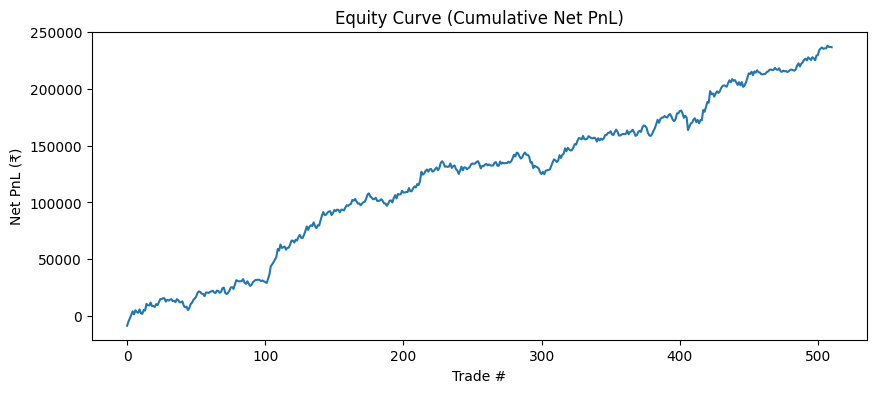

In [12]:

# ===================================
# Single Run (choose params & export)
# ===================================

best_params = dict(
    USE_RSI=True, USE_MACD=False, USE_ADX=False, USE_SMA=True, USE_BB=True,
    RSI_LEN=21, RSI_LONG_MIN=55, RSI_SHORT_MAX=50,
    MACD_FAST=12, MACD_SLOW=26, MACD_SIGNAL=9, MACD_MODE="hist_above0",
    ADX_LEN=14, ADX_MIN=20,
    SMA_FAST=10, SMA_SLOW=50,
    BB_LEN=20, BB_STD=2.0, BB_SQUEEZE_PCTL=10,
)

trades = backtest_universe(TICKERS, best_params)
if trades.empty:
    print("No trades generated. Consider loosening thresholds or adding more tickers/date range.")
else:
    trades.to_csv(TRADE_CSV_PATH, index=False)
    print(f"Saved trades to: {TRADE_CSV_PATH}\n")
    display(trades.head())

    metrics = compute_metrics(trades)
    print("=== Performance Metrics ===")
    for k,v in metrics.items():
        print(f"{k:>15}: {v:.4f}" if isinstance(v,float) else f"{k:>15}: {v}")

    plt.figure(figsize=(10,4))
    (trades['net_pnl'].cumsum()).plot(title="Equity Curve (Cumulative Net PnL)")
    plt.xlabel("Trade #")
    plt.ylabel("Net PnL (₹)")
    plt.show()



### Notes
- Grid search with indicator toggles can explode combinations. Trim `GRID` if needed.
- Trade CSV columns now include: `patterns`, `indicators_enabled`, `indicator_conf_true`, `indicator_values` (JSON at entry).
- If you'd like the **exit snapshot** logged too (indicator values at exit + reason), I can add that in a v3.
